# Imports

In [1]:
import numpy as np
import pandas as pd
import pkg_resources
import itertools
import shap
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import plotnine
from plotnine import *
plotnine.options.figure_size = (20, 10)

from xgboostlss.distributions.Gaussian_AutoGrad import Gaussian
from xgboostlss.datasets.data_loader import load_simulated_data

# Data

In [2]:
# The data is a simulated Gaussian as follows, where x is the only true feature and all others are noise variables
    # loc = 10
    # scale = 1 + 4*((0.3 < x) & (x < 0.5)) + 2*(x > 0.7)

train, test = load_simulated_data()

X_train, y_train = train.iloc[:,1:],train.iloc[:,0]
X_test, y_test = test.iloc[:,1:],test.iloc[:,0]

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Distribution and Quantile Selection

In [3]:
distribution = Gaussian                   # Estimates both location and scale parameters of the Gaussian simultaneously.
distribution.stabilize = "None"           # Option to stabilize Gradient/Hessian. Options are "None", "MAD", "L2"
quant_sel = [0.05, 0.95]

# Hyper-Parameter Optimization

In [4]:
np.random.seed(123)

# Specifies the parameters and their value range. The structure is as follows: "hyper-parameter": [lower_bound, upper_bound]. Currently, only the following hyper-parameters can be optimized:
params = {"eta": [1e-5, 1],                   
          "max_depth": [1, 10],
          "gamma": [1e-8, 40],
          "subsample": [0.2, 1.0],
          "colsample_bytree": [0.2, 1.0],
          "min_child_weight": [0, 500]
         }

opt_params = xgboostlss.hyper_opt(params,
                                  dtrain=dtrain,
                                  dist=distribution,
                                  num_boost_round=500,       # Number of boosting iterations.
                                  max_minutes=120,           # Time budget in minutes, i.e., stop study after the given number of minutes.
                                  n_trials=None,             # The number of trials. If this argument is set to None, there is no limitation on the number of trials.
                                  silence=False)             # Controls the verbosity of the trail, i.e., user can silence the outputs of the trail.

[I 2021-12-03 18:48:57,370] A new study created in memory with name: XGBoostLSS-HyperOpt
C:\Users\Alexander\.julia\v0.6\Conda\deps\usr\envs\xgboostlss\lib\site-packages\optuna\progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.


0it [00:00, ?it/s]

[I 2021-12-03 18:51:32,347] Trial 0 finished with value: 1639.3107544 and parameters: {'eta': 0.030363087280807707, 'max_depth': 3, 'gamma': 1.5074442732613943e-06, 'subsample': 0.4857160809399238, 'colsample_bytree': 0.6366741608938994, 'min_child_weight': 211}. Best is trial 0 with value: 1639.3107544.
[I 2021-12-03 18:51:53,723] Trial 1 finished with value: 1710.2045410000003 and parameters: {'eta': 0.8013476947482925, 'max_depth': 7, 'gamma': 0.0004148938237251032, 'subsample': 0.3759312069680463, 'colsample_bytree': 0.3474570556327573, 'min_child_weight': 365}. Best is trial 0 with value: 1639.3107544.
[I 2021-12-03 18:58:52,903] Trial 2 finished with value: 7877.6829589 and parameters: {'eta': 0.0015590542353378792, 'max_depth': 1, 'gamma': 6.638115717563432e-05, 'subsample': 0.6559438243964698, 'colsample_bytree': 0.26827872970098154, 'min_child_weight': 87}. Best is trial 0 with value: 1639.3107544.
[I 2021-12-03 19:06:11,758] Trial 3 finished with value: 2186.7275513 and param

# Model Training

In [5]:
np.random.seed(123)
n_rounds = opt_params["opt_rounds"]
del opt_params["opt_rounds"]

# Train Model with optimized hyper-parameters
xgboostlss_model = xgboostlss.train(opt_params,
                                    dtrain,
                                    dist=distribution,
                                    num_boost_round=n_rounds)

# Prediction

In [6]:
torch.manual_seed(123)

# Number of samples to draw from predicted distribution
n_samples=10000

# Using predicted distributional parameters, sample from distribution
pred_y = xgboostlss.predict(xgboostlss_model, 
                            dtest, 
                            dist=distribution,
                            pred_type="response",
                            n_samples=n_samples, 
                            seed=123)

# Using predicted distributional parameters, calculate quantiles
pred_quantiles = xgboostlss.predict(xgboostlss_model, 
                                    dtest, 
                                    dist=distribution,
                                    pred_type="quantiles", 
                                    quantiles=quant_sel,
                                    seed=123)


# Returns predicted distributional parameters
pred_params = xgboostlss.predict(xgboostlss_model, 
                                 dtest, 
                                 dist=distribution,
                                 pred_type="parameters")

In [7]:
pred_y.head()

,y_pred_sample_0,y_pred_sample_1,y_pred_sample_2,y_pred_sample_3,y_pred_sample_4,y_pred_sample_5,y_pred_sample_6,y_pred_sample_7,y_pred_sample_8,y_pred_sample_9,...,y_pred_sample_9990,y_pred_sample_9991,y_pred_sample_9992,y_pred_sample_9993,y_pred_sample_9994,y_pred_sample_9995,y_pred_sample_9996,y_pred_sample_9997,y_pred_sample_9998,y_pred_sample_9999
0,11.804752,9.973480,9.526457,8.515158,11.844691,12.952866,9.824673,9.257560,13.332403,6.366285,...,10.319843,7.988147,10.695857,4.493032,10.691923,15.067030,15.902285,3.355150,14.316642,6.126306
1,9.798090,15.707541,15.001865,13.190255,6.719056,13.117805,15.608835,7.842175,14.992331,5.247899,...,17.101719,7.843751,7.043964,10.054370,16.562351,8.982238,10.456743,11.755032,10.116116,1.484869
2,12.537787,10.699964,12.466835,11.383440,7.295415,11.904039,9.609749,11.105997,9.385641,7.303838,...,10.523374,12.012439,11.336312,11.609854,11.817200,8.119086,12.988430,11.806679,10.233043,10.889523
3,-0.123422,3.677409,8.579636,10.849684,16.164288,4.686682,16.691441,3.752931,12.395952,8.043407,...,7.400956,6.797948,9.536300,11.891629,6.887077,14.979828,6.616947,3.488085,5.745309,14.119503
4,11.108311,8.849730,11.086782,8.687809,9.032372,10.136565,7.478580,4.547901,12.063020,3.947788,...,9.022648,6.917824,10.275835,12.574377,8.378552,7.098277,7.216988,6.195587,4.996003,11.874951


In [8]:
pred_quantiles.head()

,y_quant_0.05,y_quant_0.95
0,4.758243,16.452660
1,3.560963,16.303991
2,7.712475,12.572285
3,-0.806894,20.597099
4,2.866322,17.105221


In [9]:
pred_params.head()

,location,scale
0,10.605452,3.554851
1,9.932477,3.873605
2,10.142380,1.477277
3,9.895103,6.506352
4,9.985771,4.328318


# SHAP Interpretability

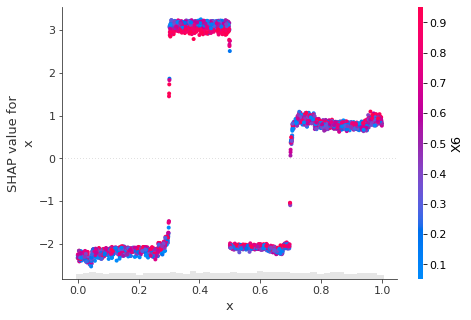

In [10]:
# Partial Dependence Plot of how x acts on scale 
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale",
                feature="x", 
                plot_type="Partial_Dependence")

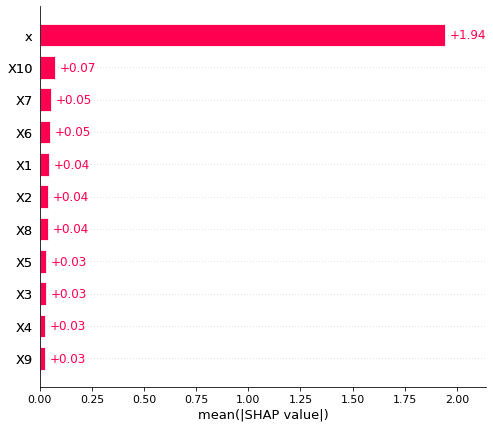

In [11]:
# Feature Importance of features on scale parameter
xgboostlss.plot(xgboostlss_model, 
                X_test, 
                parameter="scale", 
                plot_type="Feature_Importance")

# Plot of Actual vs. Predicted Quantiles

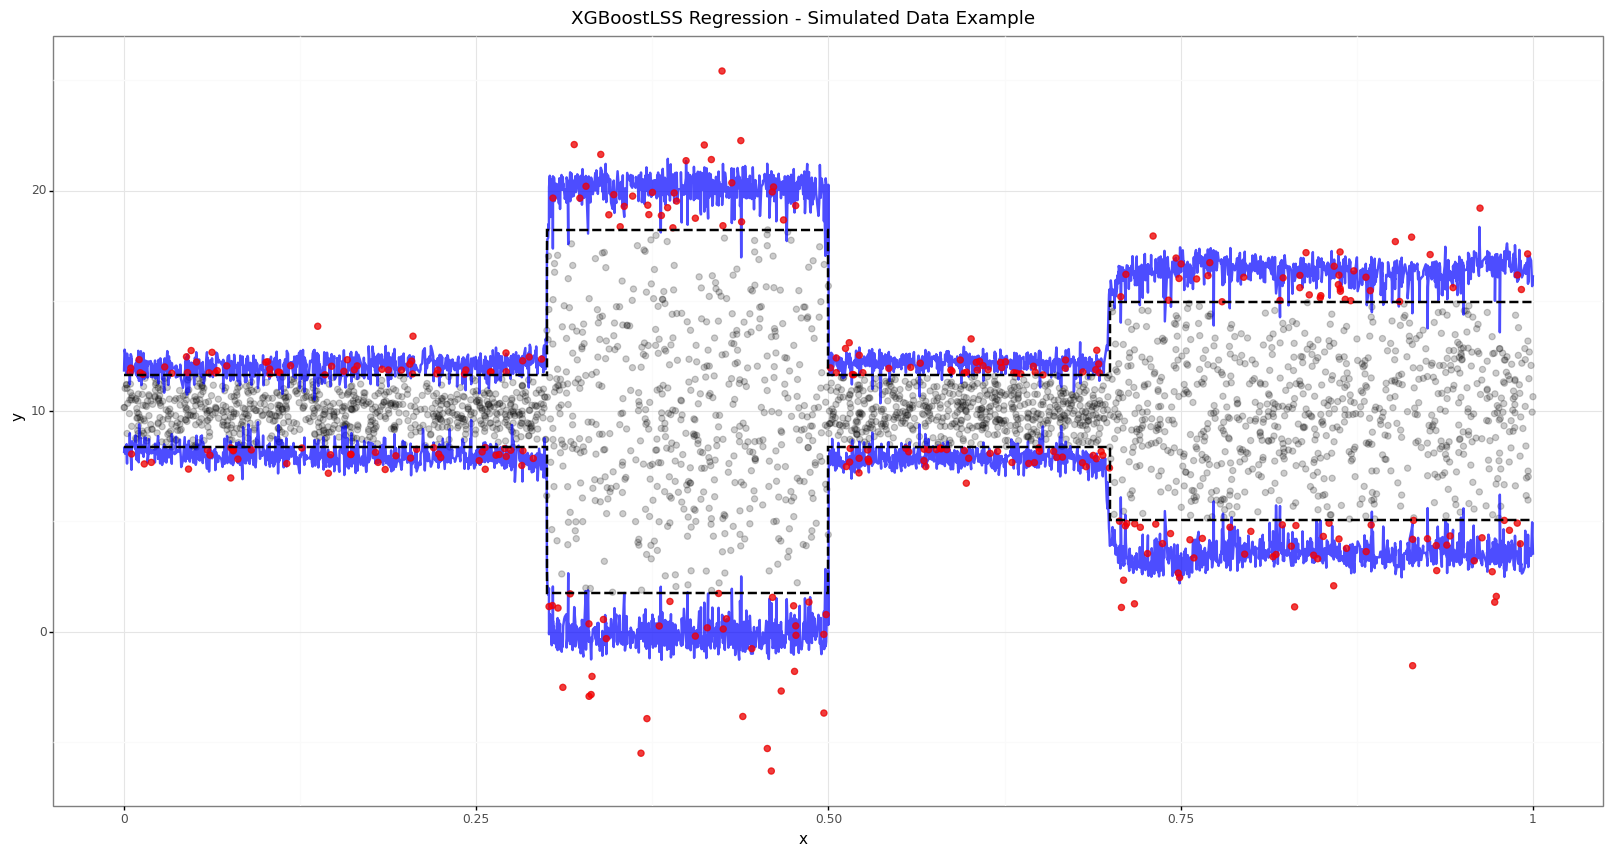

<ggplot: (-9223371937100711950)>

In [12]:
np.random.seed(123)

###
# Actual Quantiles
###
q1 = norm.ppf(quant_sel[0], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
q2 = norm.ppf(quant_sel[1], loc = 10, scale = 1 + 4*((0.3 < test["x"].values) & (test["x"].values < 0.5)) + 2*(test["x"].values > 0.7))
test["quant"] = np.where(test["y"].values < q1, 0, np.where(test["y"].values < q2, 1, 2))
test["alpha"] = np.where(test["y"].values <= q1, 1, np.where(test["y"].values >= q2, 1, 0))
df_quantiles = test[test["alpha"] == 1]

# Lower Bound
yl = list(set(q1))
yl.sort()
yl = [yl[2],yl[0],yl[2],yl[1],yl[1]]
sfunl = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yl})

# Upper Bound
yu = list(set(q2))
yu.sort()
yu = [yu[0],yu[2],yu[0],yu[1],yu[1]]
sfunu = pd.DataFrame({"x":[0, 0.3, 0.5, 0.7, 1],
                      "y":yu})



###
# Forecasted Quantiles
###
test["lb"] = pred_quantiles.iloc[:,0]
test["ub"] = pred_quantiles.iloc[:,1]



###
# Plot
###
(ggplot(test,
        aes("x",
            "y")) + 
 geom_point(alpha = 0.2, color = "black", size = 2) + 
 theme_bw() + 
 theme(legend_position="none",
       plot_title = element_text(hjust = 0.5)) +
 labs(title = "XGBoostLSS Regression - Simulated Data Example")  + 
 geom_line(aes("x",
               "ub"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_line(aes("x",
               "lb"),
           size = 1,
           color = "blue", 
           alpha = 0.7) + 
 geom_point(df_quantiles,
            aes("x",
                "y"), 
            color = "red", 
            alpha = 0.7,
            size = 2) + 
 geom_step(sfunl,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed")  + 
 geom_step(sfunu,
           aes("x",
               "y"), 
           size = 1, 
           linetype = "dashed") 
)